
___
# Predicting Clinical Outcomes for Kyphosis - 
## using the Machine Learning Random Forest Algorithm

This model uses machine learning principles to predict the success or failure of surgery to remedy Kyphosis. Kyphosis is an exaggerated forward rounding of back (spine curvature). Based on the given data and population used, the success rate for this surgery is 79%. The challenge or problem is to predict, based on patient characteristics, the surgical outcome (success or failure).

This model is presented as an illustration.  The Kyphosis data is very limited; only three features or patient characteristic are used (age, number of vertebrae involved in surgery, and the top most starting vertebra for surgery). The number of patients (81 total) is small.  The simplicity of the data does benefit the communication and understanding of the model. Hopefully, this model can be easily adapted to other applications that have many more features and thousands of patient records. 

Several machine learning algoritms could be used for this problem.  The model presented here is based on the Random Forest algorithm and the prediction (success, failure) accuracy is 76%.  Another model, using the Decison Tree algorithm, had an accuracy of 56%.  The Logistic Regression algoritm without scaling had a 68% accurracy and with scaling had 72%. It is good practice to try different algorithms. 


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

In [2]:
df = pd.read_csv('kyphosis.csv')

## Summary of the data:
- All these (81) patients (children) have been diagnosis with Kyphosis. Kyphosis is an exaggreated, forward rounding of the back. It can occur at any age but is most common in older women. Some is congenital. 
- All these patients have spine surgery for eliminate the Kyphosis. Kyphosis (absent, present) is the outcome of surgery. 'Absent' is good.  
- Age is in months (children)
- Number is number of vertebrae involved
- Start is the vertebra where procedure started (top most)

- Source of data is Kaggle: https://www.kaggle.com/abbasit/kyphosis-dataset

## The problem:
- The surgical success rate at less than 79% is a concern.
- Given this historical data, predict the outcome (absent, present) a new patient given their features (Age, Number, Start).
- What's the accuracy of this prediction?

### Sample of data

In [3]:
print('\nData elements and some data:\n', df.head(3))


Data elements and some data:
   Kyphosis  Age  Number  Start
0   absent   71       3      5
1   absent  158       3     14
2  present  128       4      5


### Restructure the data

In [4]:
df['Category'] = ' '                         # This will be indicator for Test or Train
df["Ground"] = np.where (df['Kyphosis']=='absent', 1,0)
df=df.drop('Kyphosis',axis=1)
df.head(2)

,Age,Number,Start,Category,Ground
0,71,3,5,,1
1,158,3,14,,1


## Explore the Data


In [5]:
print ("Number of patients: ", df.shape[0], "(also equals number of surgeries)")
absent_cnt = df.loc[df['Ground'] == 1].count()[0]     # number of successful surgeries
present_cnt = df.loc[df["Ground"] == 0].count()[0]     # number of failed surgeries
print('\nSurgery: success count {}, failure count {}; success rate: {: .1f}% '.format(absent_cnt,present_cnt,(absent_cnt / df.shape[0]*100)))


Number of patients:  81 (also equals number of surgeries)

Surgery: success count 64, failure count 17; success rate:  79.0% 


In [6]:
def quartile_calc(df1, var):
    """ 
    Purpose: Establish quartiles for each feature
    Inputs: 
        dataframe (containing both features and outcome in columns). Outcome column must be labeled 'Outcomes'
        var (column name for x axis)
    Outputs:
        positive outcomes per quartile in form of [n,n,n,n]
        negative outcomes per quartile in form of [n,n,n,n] 
        quartiles 
    Assumptions:
        Column "Outcome" in dataframe with '1' for positive outcome, zero otherwise.
    """
    range_x = df1[var].max() - df1[var].min()
    qtr_size = -(-range_x // 4)
    qtr_x = [1*qtr_size,2*qtr_size,3*qtr_size,4*qtr_size ]
    #print(">>>Variable:", var, ";  Range", df1[var].min(), df1[var].max(), ";  Quartiles:", qtr_x)
    y_pos = [0,0,0,0]                     # quartile counts for pos outcomes
    y_neg = [0,0,0,0]                     # quartile counts for neg outcomes
    for i in range(df1.shape[0]):
        if df1.iloc[i][var] <= qtr_x[0]:
            if df1.iloc[i]['Ground'] == 1: y_pos[0] += 1
            else: y_neg[0] += 1
        elif df1.iloc[i][var] <= qtr_x[1]:
            if df1.iloc[i]['Ground'] == 1: y_pos[1] += 1
            else: y_neg[1] += 1
        elif df1.iloc[i][var] <= qtr_x[2]:
            if df1.iloc[i]['Ground'] == 1: y_pos[2] += 1
            else: y_neg[2] += 1
        else:
            if df1.iloc[i]['Ground'] == 1: y_pos[3] += 1
            else: y_neg[3] += 1 
    return y_pos, y_neg, qtr_x

def table(x_features, dfx):
    """
    Purpose: Create a table (dataframe) for feature statistics
    Inputs:
        List of features
        Dataframe
    Outputs:
        Table in dataframe format
    """
    tablex = np.ones(len(x_features)*5).reshape(len(x_features), 5)
    dftable= pd.DataFrame(tablex, index=x_features, columns= ['Range_Min','Range_Max','Mean', 'Stdev', 'Range_Quartiles'] )
    dftable = dftable.astype(np.int64)
    for feat in x_features:
        dftable.loc[feat,'Range_Min']= int(dfx[feat].min())
        dftable.loc[feat,'Range_Max']= int(dfx[feat].max())
        dftable.loc[feat,'Mean']= int(dfx[feat].mean())
        dftable.loc[feat, 'Stdev'] = str(round(dfx[feat].std(),1))
        dftable.loc[feat, 'Range_Quartiles']= str(quartile_calc(dfx, feat)[2])
    return dftable

In [7]:
features = df.columns[0:3]
table(features,df)

,Range_Min,Range_Max,Mean,Stdev,Range_Quartiles
Age,1,206,83,58.1,"[52, 104, 156, 208]"
Number,2,10,4,1.6,"[2, 4, 6, 8]"
Start,1,18,11,4.9,"[5, 10, 15, 20]"


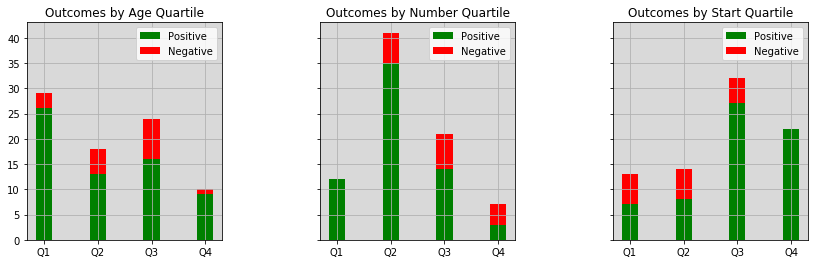

In [8]:
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(14,4),sharex='col',sharey='row')
fig.subplots_adjust(hspace= 10, wspace=.5)
for i in range(len(features)):
    y_pos,y_neg,x = quartile_calc(df, features[i])             # Call function to calculate quartile data
    axs[i].bar(['Q1','Q2','Q3','Q4'], y_pos, width=.3, color = 'g')
    axs[i].bar(['Q1','Q2','Q3','Q4'], y_neg, bottom=y_pos, width =.3,color = 'r')
    axs[i].set_yticks(np.arange(0, 45, 5))
    axs[i].set_title("Outcomes by " + features[i] + ' Quartile')
    axs[i].legend(['Positive', 'Negative'])
    axs[i].set_facecolor('0.85')          # light gray
    axs[i].grid()
    


## Train Test Split

Split the data into a training set and a test set.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df[['Age','Number', 'Start'] ]                   #  X = features
y = df['Ground']                                     #  y = outcomes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [11]:
# Flag the randomly selected train and test entries for future analysis
df["Category"] = "Train"
for i in X_test.index:
    df.at[i, 'Category'] = 'Test'
print(df.head(3))


   Age  Number  Start Category  Ground
0   71       3      5    Train       1
1  158       3     14    Train       1
2  128       4      5     Test       0


### Set up Random Forest Model

In [12]:
#from numpy.core.umath_tests import inner1d
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=101, random_state=242, oob_score=True)
rfc.fit(X_train, y_train)


C:\Users\rernst\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=101, n_jobs=1, oob_score=True, random_state=242,
            verbose=0, warm_start=False)

### Make predictions on the test dataset

In [13]:
rfc_pred = rfc.predict(X_test)

In [14]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Predictions from evaluate:\n', len(predictions),'entries:',  predictions)
    errors = predictions - test_labels
    accuracy = (1- errors.sum() / len(predictions))*100
    return accuracy

print('Model Performance (Accuracy):')
print ("   Train Accuracy:", evaluate(rfc, X_train, y_train))
print ("   Test Accuracy: ", evaluate(rfc, X_test, y_test))

Model Performance (Accuracy):
Predictions from evaluate:
 56 entries: [1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1]
   Train Accuracy: 100.0
Predictions from evaluate:
 25 entries: [1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
   Test Accuracy:  76.0


### Calculate Accuracy

In [15]:
from sklearn.metrics import classification_report,confusion_matrix

def prt_confusion(xmatrix):
    print('Confusion Matrix:')
    print('True Positives : {}   False Positives: {}'.format(xmatrix[0][0], xmatrix[0][1]))
    print('False Negatives: {}   True Negatives:  {}'.format(xmatrix[1][0], xmatrix[1][1]))
    print('\nAccuracy [(TP+TN)/(FN+FP)]: {: .1f}% '.format((xmatrix[0][0]+ xmatrix[1][1])/ xmatrix.sum() * 100 ))
    return

matrix= confusion_matrix(y_test,rfc_pred)
prt_confusion(matrix)

Confusion Matrix:
True Positives : 2   False Positives: 6
False Negatives: 0   True Negatives:  17

Accuracy [(TP+TN)/(FN+FP)]:  76.0% 


In [16]:
print('Classification Report: \n\n', classification_report(y_test,rfc_pred))

Classification Report: 

              precision    recall  f1-score   support

          0       1.00      0.25      0.40         8
          1       0.74      1.00      0.85        17

avg / total       0.82      0.76      0.71        25




Precision is the ability of the classifier not to label as positive a sample that is negative.
Recall is the ability of the classifier to find all the positive samples.

### Conclusion: Model overfits the training data and under-performs on test data

#### Some interpretations and Conclusions
The high number of True Negatives is good for knowing when the surgery is ill advised. The low (zero) False Negatives reinforces this prediction.

The high False Positives combined with low number of True Positives indicate a prediction of success is near meaningless and harmful. 

Accuracy and these conclusions may be improved by adding features (bone density, number of prior surgeries, weight relative to expected weight, comorbidities, etc). Accuracy may also be improved by increasing the number of patients.

Cross Validation (averaging different subsets of the training data) was also used (unsuccessful) to garner additional information from the training data and to fix the overfitting. 

